# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [2]:
df = pd.read_csv("data/vehicles.csv")
print("What features does vehicles data have?\n", list(df.columns))

What features does vehicles data have?
 ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']


The objective is to formulate a regression task using supervised learning to model the relationship between a set of predictor features (e.g., year, odometer, manufacturer, condition, fuel, transmission, and state) and the continuous target variable (price). We will build a predictive model to accurately estimate the vehicle's sale price. Using this model, we will quantify the relationship between these predictors and price, and use techniques like feature importance and model coefficients to identify which variables are the primary drivers of used car prices and how strongly they influence the target.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
print("DataFrame Info (data types and non-null values):")
df.info()

DataFrame Info (data types and non-null values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17 

In [4]:
print("Descriptive Statistics:")
display(df.describe())

Descriptive Statistics:


,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### Let's split columns into numeric and categorical variables

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("Numeric columns:", list(numeric_cols))

categorical_cols = df.select_dtypes(include=["object"]).columns
print("\nCategorical columns:", list(categorical_cols))

Numeric columns: ['id', 'price', 'year', 'odometer']

Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']


### The target key variables, 'price', 'year', 'Odometer' should be examined for distribution, tendency, spread and the presence of outliers.

#### Basic statistics

In [6]:
key_cols = ['price', 'year', 'odometer']
print("Summary for key numeric variables:")
df[key_cols].describe().T

Summary for key numeric variables:


,count,mean,std,min,25%,50%,75%,max
price,426880.0,75199.033187,1.218228e+07,0.0,5900.0,13950.0,26485.75,3.736929e+09
year,425675.0,2011.235191,9.452120e+00,1900.0,2008.0,2013.0,2017.00,2.022000e+03
odometer,422480.0,98043.331443,2.138815e+05,0.0,37704.0,85548.0,133542.50,1.000000e+07


#### Distribution of key numeric features

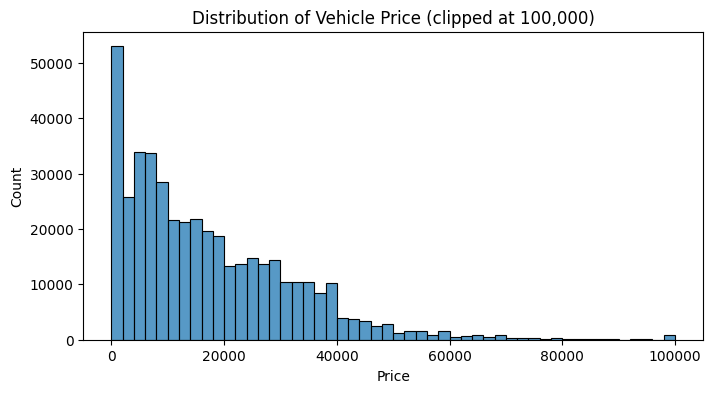

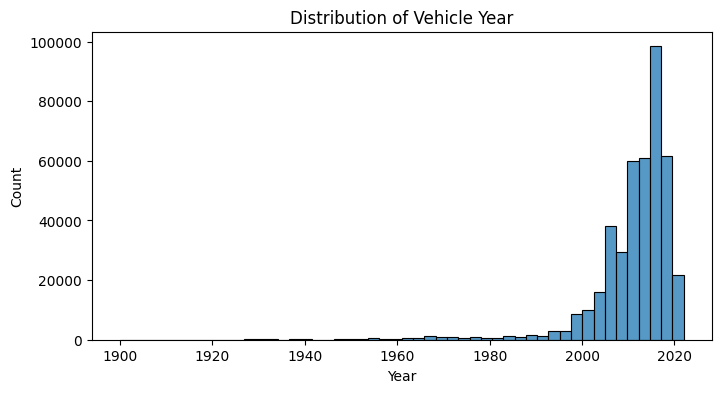

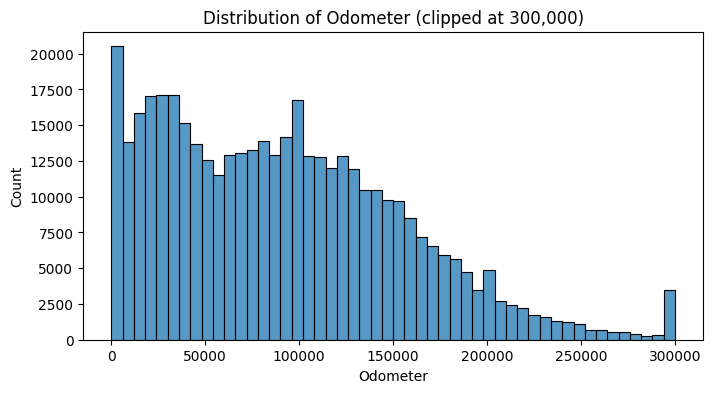

In [7]:
## Let's limit the maximum value for readability
plot_config = {
    "price": {
        "clip": (0, 100000),
        "title": "Distribution of Vehicle Price (clipped at 100,000)"
    },
    "year": {
        "clip": None,
        "title": "Distribution of Vehicle Year"
    },
    "odometer": {
        "clip": (0, 300000),
        "title": "Distribution of Odometer (clipped at 300,000)"
    }
}

for col, cfg in plot_config.items():
    if col in df.columns:
        plt.figure(figsize=(8, 4))

        data = df[col].dropna()

        # Apply clipping if specified
        if cfg["clip"] is not None:
            low, high = cfg["clip"]
            data = data.clip(lower=low, upper=high)

        sns.histplot(data, bins=50)
        plt.title(cfg["title"])
        plt.xlabel(col.capitalize())
        plt.ylabel("Count")
        plt.show()


#### Distribution for categorical values

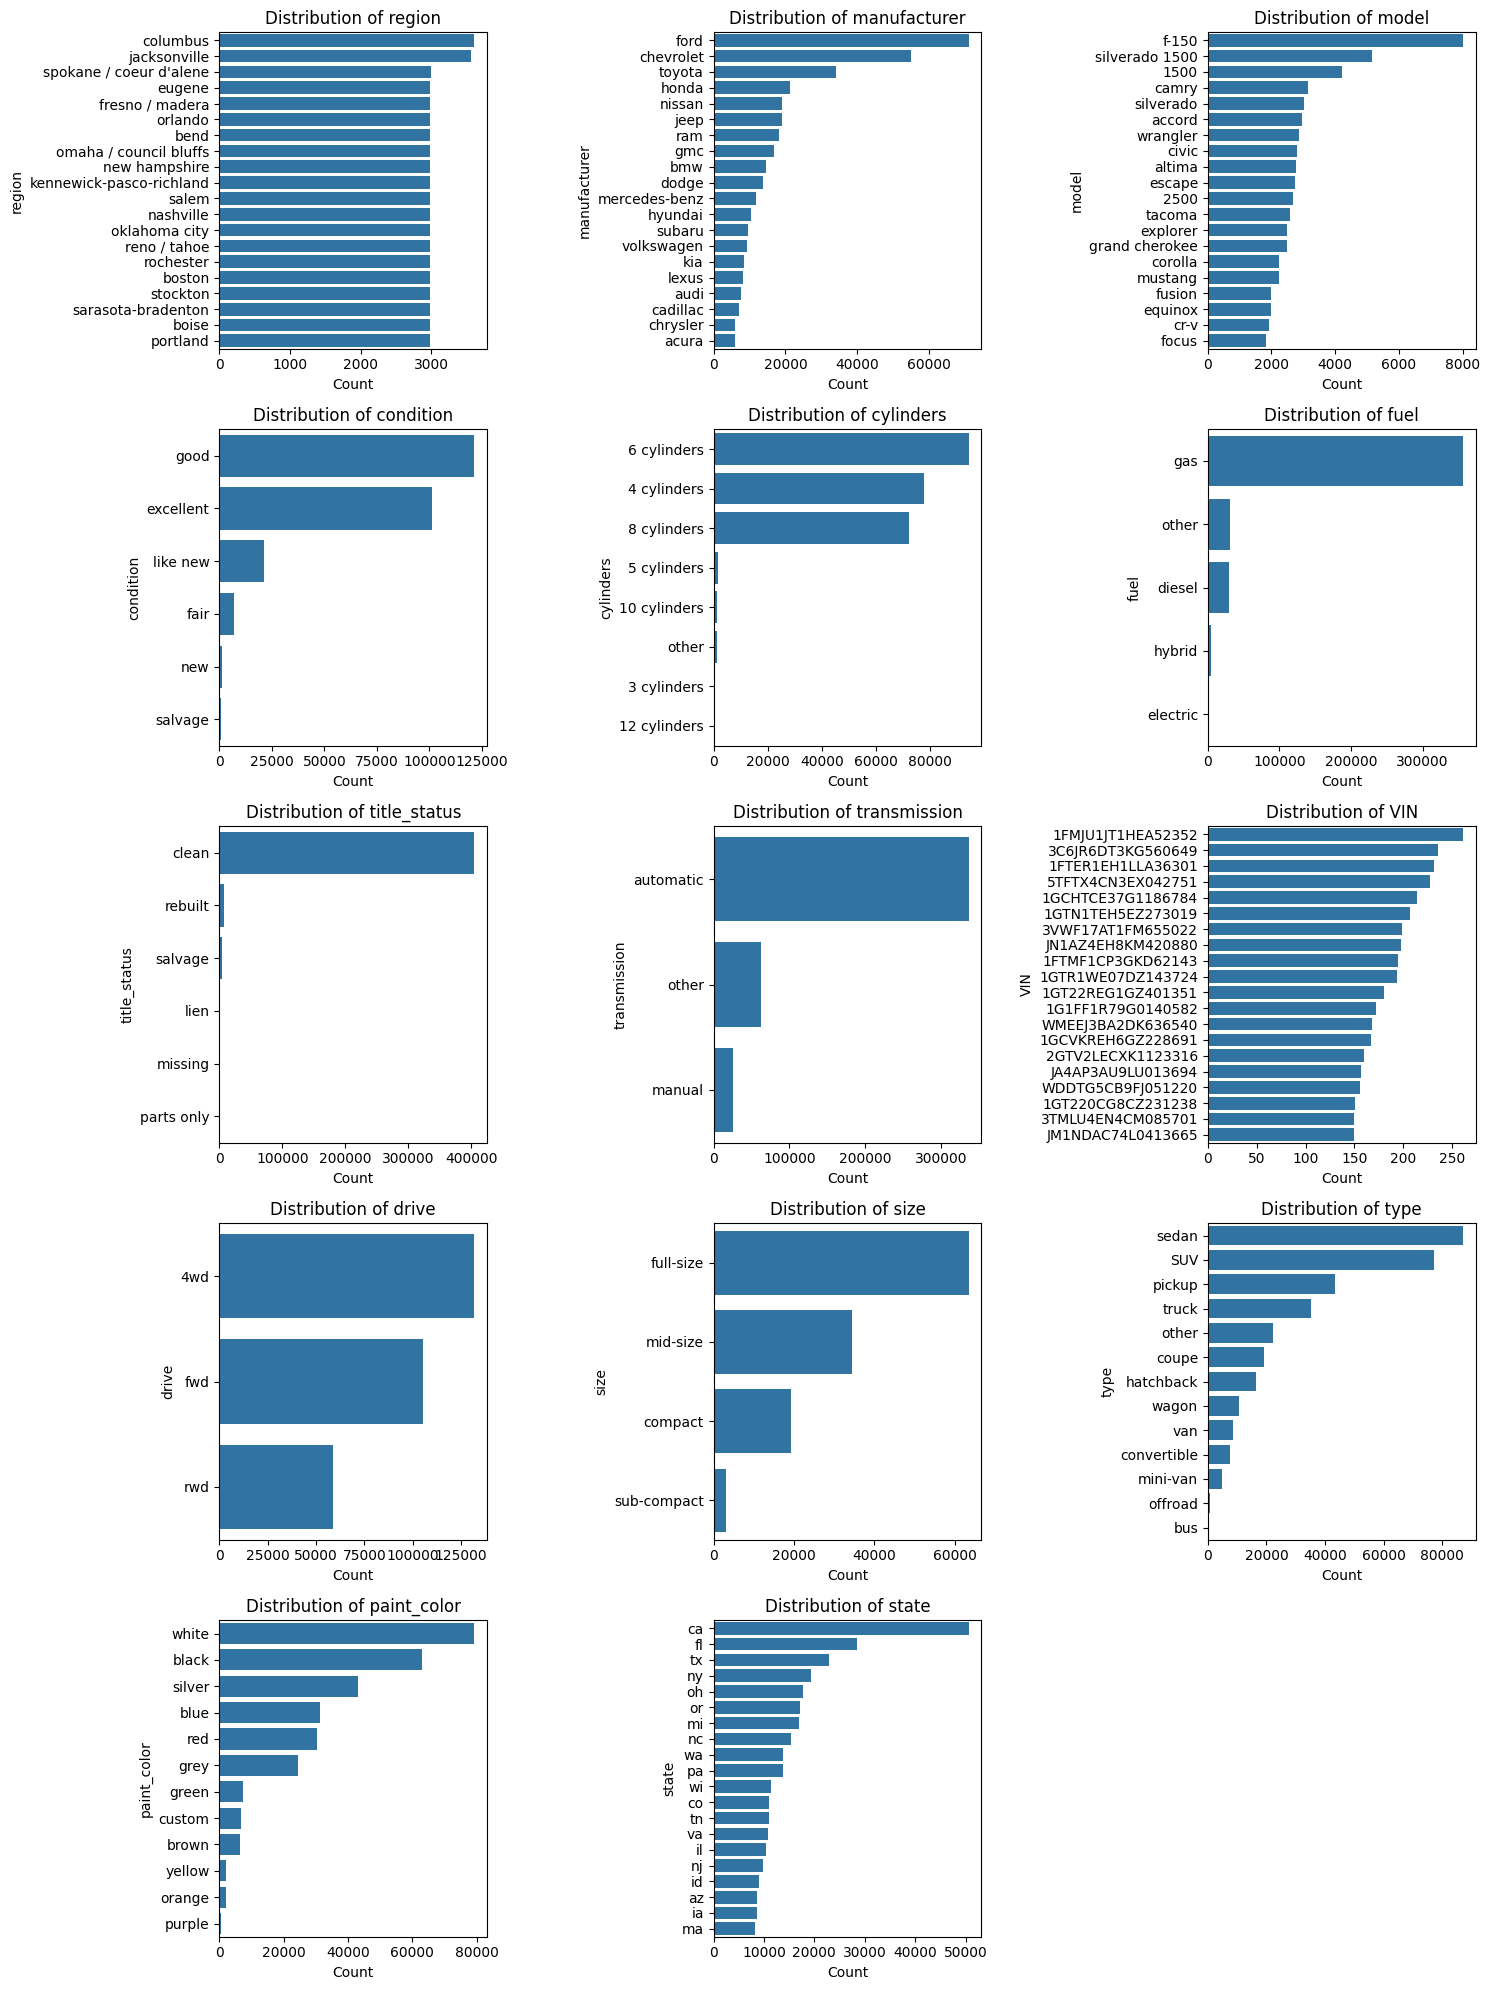

In [8]:
# Setup subplot grid
n = len(categorical_cols)
rows = (n + 2) // 3   # 3 plots per row
cols = 3

plt.figure(figsize=(15, rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(
        y=df[col],
        order=df[col].value_counts().head(20).index   # limit to top 20 for readability
    )
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.xlabel("Count")

plt.tight_layout()
plt.show()

### Let's take a closer look at the relationshops: price vs key numeric features, categorical values

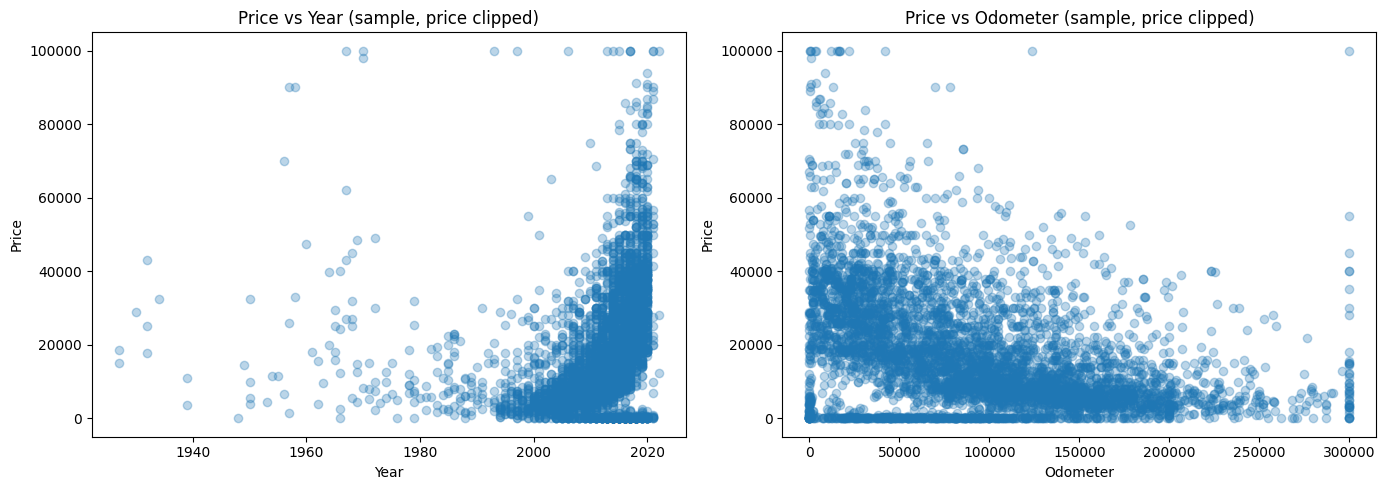

In [9]:
# Create a sample (optional, for speed)
sample = df.sample(min(5000, len(df)), random_state=42)

# Prepare the 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Plot 1: Price vs Year ----
if set(["price", "year"]).issubset(sample.columns):
    # Create a temporary DataFrame from sample with relevant columns, drop NaNs
    plot_data_year = sample[['year', 'price']].dropna()
    # Apply clipping to the 'price' column in the temporary DataFrame
    plot_data_year['price'] = plot_data_year['price'].clip(lower=0, upper=100000)
    axes[0].scatter(plot_data_year["year"], plot_data_year["price"], alpha=0.3)
    axes[0].set_title("Price vs Year (sample, price clipped)")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Price")

# ---- Plot 2: Price vs Odometer ----
if set(["price", "odometer"]).issubset(sample.columns):
    # Create a temporary DataFrame from sample with relevant columns, drop NaNs
    plot_data_odometer = sample[['odometer', 'price']].dropna()
    # Apply clipping to the 'odometer' column in the temporary DataFrame
    plot_data_odometer['odometer'] = plot_data_odometer['odometer'].clip(lower=0, upper=300000)
    plot_data_odometer['price'] = plot_data_odometer['price'].clip(lower=0, upper=100000)
    axes[1].scatter(plot_data_odometer["odometer"], plot_data_odometer["price"], alpha=0.3)
    axes[1].set_title("Price vs Odometer (sample, price clipped)")
    axes[1].set_xlabel("Odometer")
    axes[1].set_ylabel("Price")

plt.tight_layout()
plt.show()

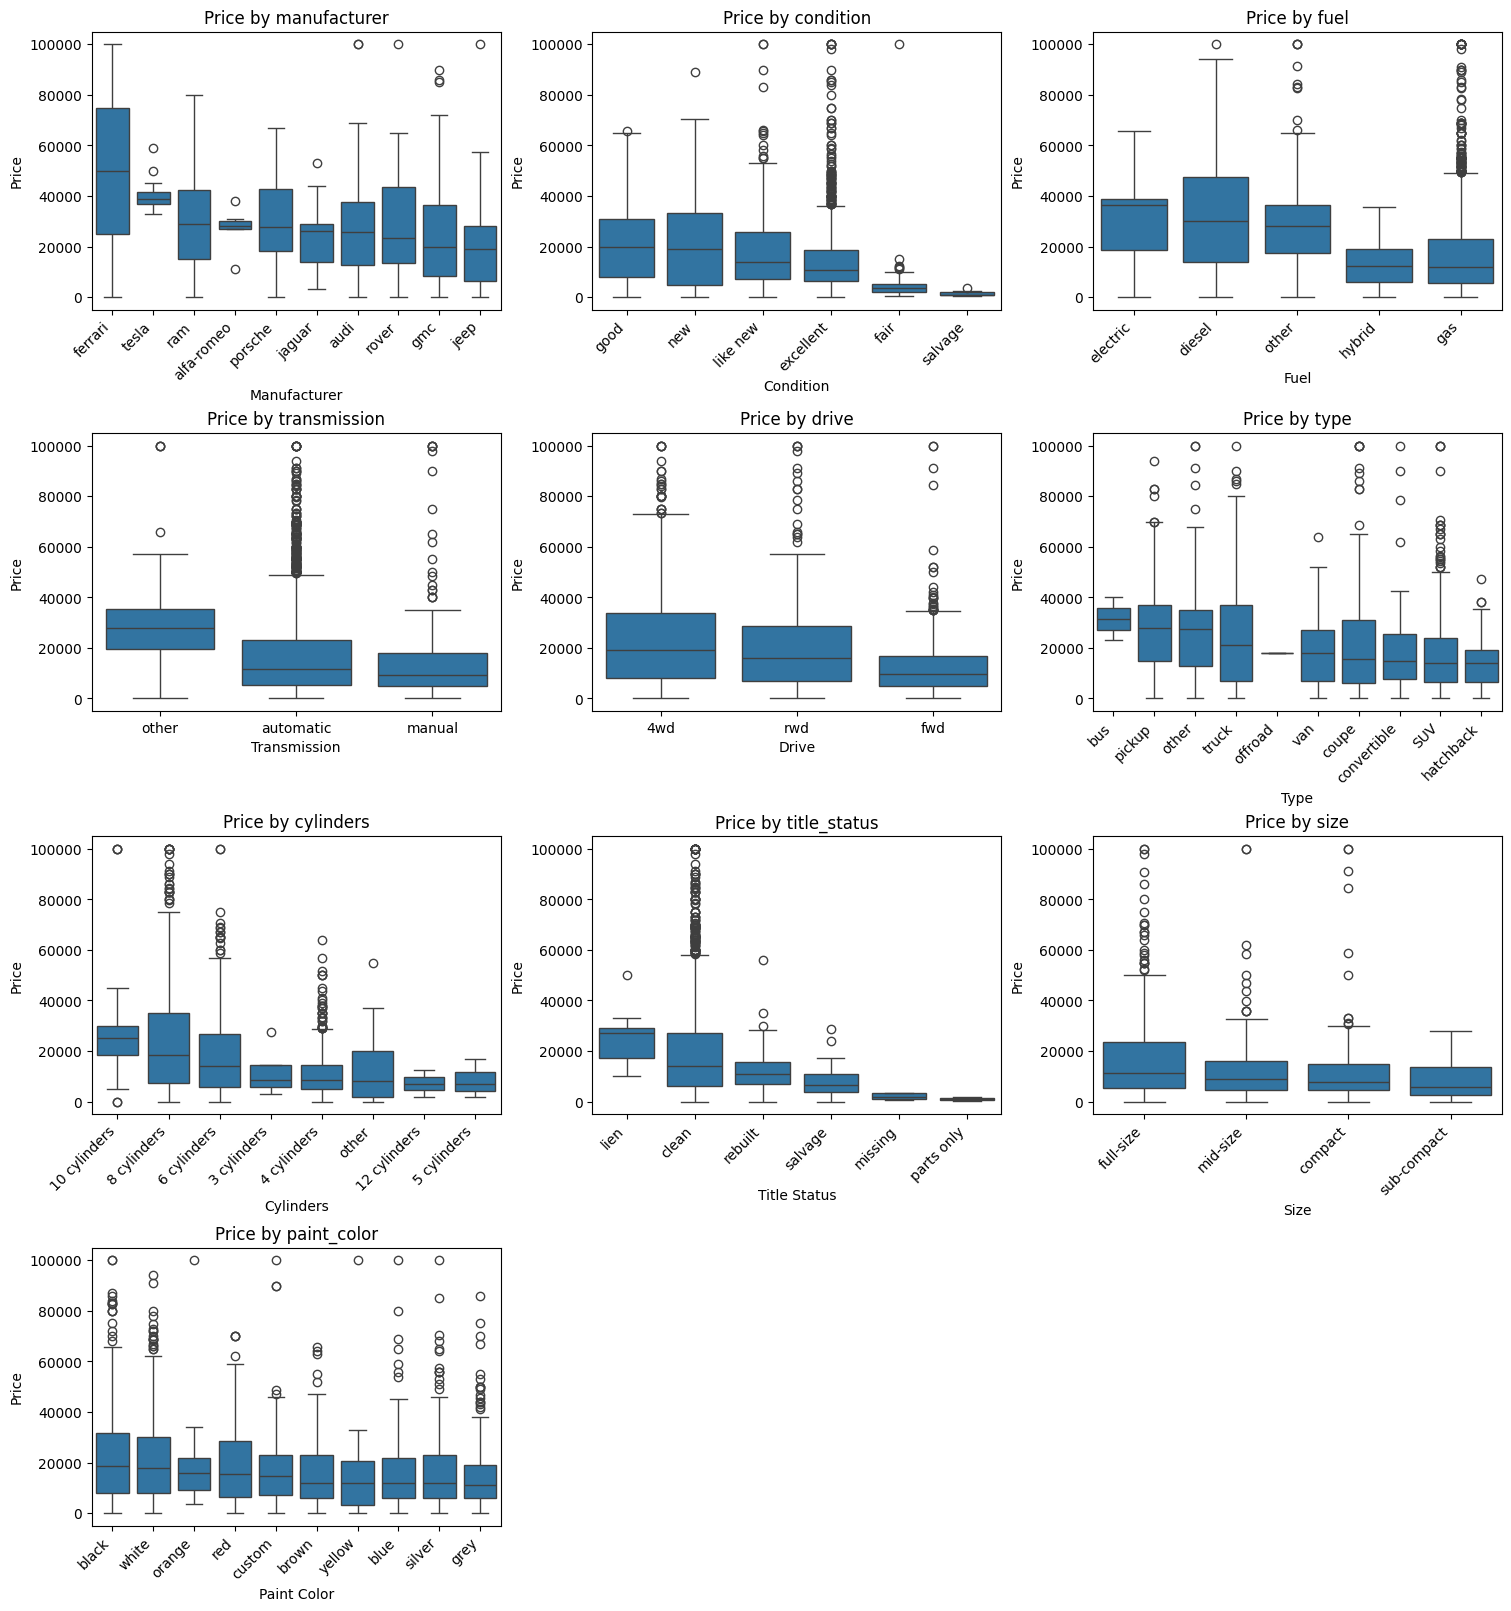

In [10]:
# Use the existing 'sample' DataFrame
categorical_cols_to_plot = [
    'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type',
    'cylinders', 'title_status', 'size', 'paint_color'
]

# Setup subplot grid
n_plots = len(categorical_cols_to_plot)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
axes = axes.flatten()

price_clip_upper = 100000 # Using the previously defined clip for price

for i, col in enumerate(categorical_cols_to_plot):
    ax = axes[i]
    if col in sample.columns:
        plot_data = sample[[col, 'price']].dropna()
        plot_data['price'] = plot_data['price'].clip(upper=price_clip_upper)

        # Get categories sorted by median price
        category_medians = plot_data.groupby(col)['price'].median().sort_values(ascending=False)

        # Determine the categories to display (top N if there are many)
        top_n = 10 # Limiting to 10 for better readability
        if len(category_medians) > top_n:
            order = category_medians.head(top_n).index
        else:
            order = category_medians.index

        # Filter plot_data to only include the selected categories
        plot_data_filtered = plot_data[plot_data[col].isin(order)]

        sns.boxplot(x=col, y='price', data=plot_data_filtered, order=order, ax=ax)
        ax.set_title(f'Price by {col}')
        ax.set_xlabel(col.replace('_', ' ').title()) # Clean up x-axis label
        ax.set_ylabel('Price')
        if len(order) > 3: # Rotate x-axis labels if many categories
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Remove any unused subplots if the number of plots is not a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

#### 1. Data Initialization and Irrelevant Feature Removal

In [11]:
df_clean = df.copy()

##### Let's remove irrelevant colums. Through the data exploratoin, we figured out that  'id', 'VIN', 'model', 'region', 'paint_color' are less importanct features and could be removed in building prediction models

In [12]:
cols_to_drop = ["id", "VIN", "model", "region", "paint_color"]
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns],
    errors="ignore")

#### 2.Handling Missing Data and Outlier Filtering

In [13]:
# A. Drop rows missing critical numerical values (Price, Year, Odometer) for simplicity
df_clean = df_clean.dropna(subset=["price", "year", "odometer"])

# B. Enforce logical constraints on the 'price' target variable.
# Keep only cars priced between $500 and $100,000 to remove outliers (0 price, or super-luxury cars).
df_clean = df_clean[
    (df_clean["price"] >= 500) & (df_clean["price"] <= 100000)
]

# C. Enforce logical constraints on 'year'.
# Keep only cars manufactured between 1950 and 2024 (avoiding extremely old or future years).
df_clean = df_clean[
    (df_clean["year"] >= 1950) & (df_clean["year"] <= 2024)
]

# D. Enforce logical constraints on 'odometer'.
# Keep cars with a practical mileage up to 300,000 miles.
df_clean = df_clean[
    (df_clean["odometer"] >= 0) & (df_clean["odometer"] <= 300000)
]

#### 3.Feature Engineering
Age: Create 'vehicle_age' (2024 - df['year'] to better capture depreciation trends.

Price & Odometer: Apply log-transformation to these highly skewed variables to improve model performance.

In [14]:
df_clean["vehicle_age"] = 2024 - df_clean["year"]

df_clean["log_price"] = np.log1p(df_clean["price"])
df_clean["log_odometer"] = np.log1p(df_clean["odometer"])

In [15]:
feature_cols = [
    "vehicle_age",
    "log_odometer",
    "manufacturer",
    "condition",
    "fuel",
    "cylinders",
    "title_status",
    "transmission",
    "drive",
    "type",
    "state",
]
target_col = "log_price"
df_final = df_clean[feature_cols + [target_col]]
# Drop rows that still contain missing categorical values
df_final.dropna(inplace=True)
print("Final dataset shape:", df_final.shape)
df_final.head()

Final dataset shape: (120454, 12)


,vehicle_age,log_odometer,manufacturer,condition,fuel,cylinders,title_status,transmission,drive,type,state,log_price
31,11.0,11.759793,ford,excellent,gas,6 cylinders,clean,automatic,rwd,truck,al,9.615872
32,12.0,11.137461,gmc,good,gas,8 cylinders,clean,other,4wd,pickup,al,10.239638
33,8.0,10.292146,chevrolet,good,gas,6 cylinders,clean,other,4wd,pickup,al,10.451349
34,5.0,10.668979,toyota,excellent,gas,6 cylinders,clean,automatic,4wd,truck,al,10.463132
35,8.0,9.758635,chevrolet,good,gas,6 cylinders,clean,other,4wd,pickup,al,10.308653


#### 4. Data preprocessing

In [16]:
from types import prepare_class
# Split into X and y
X = df_final[feature_cols]
y = df_final[target_col]

# numeric + categorical features
numeric_features = ['vehicle_age', 'log_odometer']
categorical_features = ['manufacturer', 'condition', 'fuel', 'cylinders', 'title_status', 'transmission', 'drive', 'type', 'state']

# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### LinearRegression()



In [17]:
linreg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

linreg_model.fit(X_train, y_train)

# Predictions
y_pred = linreg_model.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred)


print("Linear Regression Results")
print("---------------------------")
print(f"MSE: {mse_lr:,.2f}")

Linear Regression Results
---------------------------
MSE: 0.28


#### Lasso Regression


In [18]:
# Lasso model pipeline
lasso_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", Lasso(max_iter=5000))
    ]
)
# print pipeline
lasso_pipe

# Hyperparameter tuning
lasso_params = {"regressor__alpha": [0.001, 0.01, 0.1, 1.0]}

lasso_grid = GridSearchCV(
    lasso_pipe,
    param_grid=lasso_params,
    cv=3
)

lasso_grid.fit(X_train, y_train)

# Best model
lasso_best = lasso_grid.best_estimator_
y_pred_lasso = lasso_best.predict(X_test)

mse_la = mean_squared_error(y_test, y_pred_lasso)

print("Lasso Regression")
print("---------------------------")
print("Best alpha:", lasso_grid.best_params_)
print(f"MSE: {mse_la:,.2f}")

Lasso Regression
---------------------------
Best alpha: {'regressor__alpha': 0.001}
MSE: 0.29


In [19]:
prediction_results = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso Regression"],
    "MSE": [mse_lr, mse_la]
})
display(prediction_results)

,Model,MSE
0,Linear Regression,0.284648
1,Lasso Regression,0.290566


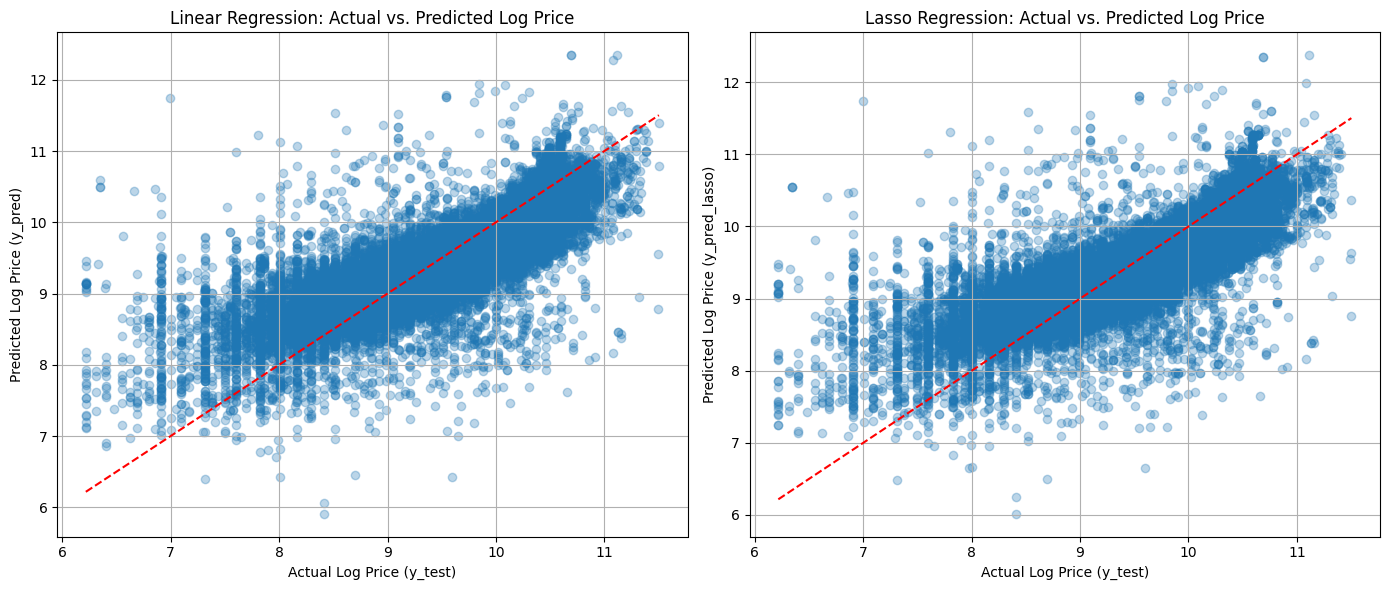

In [20]:
plt.figure(figsize=(14, 6))

# Scatter plot for Linear Regression
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # Perfect prediction line
plt.title('Linear Regression: Actual vs. Predicted Log Price')
plt.xlabel('Actual Log Price (y_test)')
plt.ylabel('Predicted Log Price (y_pred)')
plt.grid(True)

# Scatter plot for Lasso Regression
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.scatter(y_test, y_pred_lasso, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # Perfect prediction line
plt.title('Lasso Regression: Actual vs. Predicted Log Price')
plt.xlabel('Actual Log Price (y_test)')
plt.ylabel('Predicted Log Price (y_pred_lasso)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [21]:
ohe = linreg_model.named_steps['preprocess'].named_transformers_['cat']['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

coefs = linreg_model.named_steps['regressor'].coef_
factors = pd.DataFrame({'feature': feature_names, 'coef': coefs}).sort_values('coef', ascending=False)
display(factors.head(20))

,feature,coef
32,manufacturer_morgan,2.369098
13,manufacturer_ferrari,1.569215
11,manufacturer_datsun,1.061342
40,manufacturer_tesla,0.710565
4,manufacturer_aston-martin,0.533687
56,cylinders_12 cylinders,0.481135
47,condition_like new,0.434823
35,manufacturer_porsche,0.401585
64,title_status_lien,0.397202
44,condition_excellent,0.390394


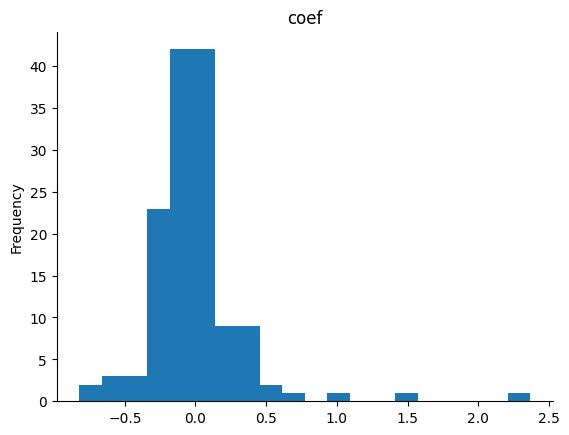

In [22]:
factors['coef'].plot(kind='hist', bins=20, title='coef')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Key Takeaways for the Dealership

1. Customers prefer cars that are newer and have lower mileage.
These cars are worth more and sell more easily. The dealership should try to buy more of them.

2. Car brand matters a lot.
Brands like Toyota, Honda, Subaru, Lexus, and BMW usually sell for higher prices because people trust them more.

3. The car’s condition and title status strongly affect the price.
Cars in good condition or with a clean title are much more valuable.
Small repairs or cleaning can increase the selling price.

4. AWD and 4WD vehicles, as well as SUVs and trucks, are more popular in some regions.
The dealership should choose inventory based on what local customers need (weather, terrain, etc.).

5. Prices differ by state or region.
The dealership may be able to buy cars cheaply in some areas and sell them for higher prices in others.